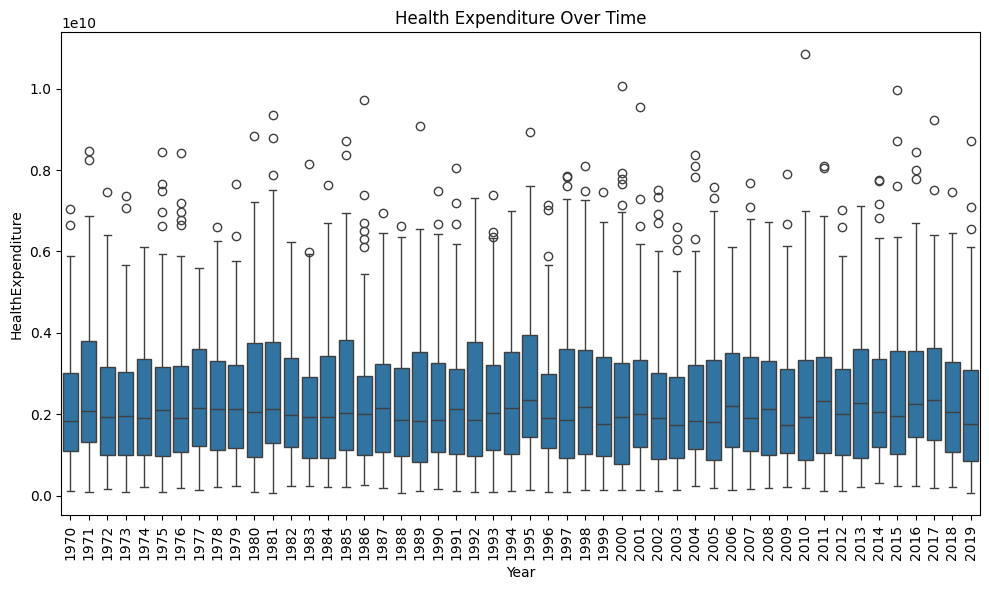


📌 Fixed Effects Model Summary:
                           PanelOLS Estimation Summary                           
Dep. Variable:      HealthExpenditure   R-squared:                        0.0007
Estimator:                   PanelOLS   R-squared (Between):              0.9751
No. Observations:                5000   R-squared (Within):               0.0007
Date:                Thu, May 29 2025   R-squared (Overall):              0.6727
Time:                        20:14:24   Log-likelihood                -1.132e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.1543
Entities:                         100   P-value                           0.3257
Avg Obs:                       50.000   Distribution:                  F(3,4897)
Min Obs:                       50.000                                           
Max Obs:                       50.000   F-statistic (robust):             1.

/usr/local/lib/python3.11/dist-packages/linearmodels/panel/data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
/usr/local/lib/python3.11/dist-packages/linearmodels/panel/data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
/usr/local/lib/python3.11/dist-packages/linearmodels/panel/data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

In [2]:
# 📦 Install required packages (only once)
!pip install linearmodels statsmodels --quiet

# 📚 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS, RandomEffects
from statsmodels.formula.api import ols

# 📊 Load the dataset
df = pd.read_csv('Health_Expenditure_Panel_Dataset.csv')

# 🧼 Data Cleaning
df.dropna(inplace=True)  # Drop missing values if any
df['RegionID'] = df['RegionID'].astype('category')
df['Year'] = pd.to_numeric(df['Year'])  # Ensure Year is numeric

# 📌 Set index for panel data
df = df.set_index(['RegionID', 'Year'])

# 📊 Visualization: Distribution of Health Expenditure by Region
plt.figure(figsize=(10, 6))
sns.boxplot(x='Year', y='HealthExpenditure', data=df.reset_index())
plt.title("Health Expenditure Over Time")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 🎯 Define Dependent and Independent Variables
# HealthExpenditure = β0 + β1*Income + β2*MortalityRate + β3*LifeExpectancy + ui
dependent = 'HealthExpenditure'
independent_vars = ['IncomePerCapita', 'MortalityRate', 'LifeExpectancy']
formula = dependent + ' ~ ' + ' + '.join(independent_vars)

# -------------------------
# 🔁 1. Fixed Effects Model
# -------------------------
fe_model = PanelOLS.from_formula(formula + ' + EntityEffects', data=df).fit()
print("\n📌 Fixed Effects Model Summary:\n", fe_model)

# -------------------------
# 🔁 2. Random Effects Model
# -------------------------
re_model = RandomEffects.from_formula(formula, data=df).fit()
print("\n📌 Random Effects Model Summary:\n", re_model)

# -------------------------
# 🧪 Hausman Test Function
# -------------------------
def hausman(fe, re):
    b = fe.params[independent_vars]
    B = re.params[independent_vars]
    v_b = fe.cov.loc[independent_vars, independent_vars]
    v_B = re.cov.loc[independent_vars, independent_vars]
    df_h = len(b)
    stat = (b - B).T @ np.linalg.inv(v_b - v_B) @ (b - B)
    pval = 1 - stats.chi2.cdf(stat, df_h)
    return stat, pval

from scipy import stats
hausman_stat, p_value = hausman(fe_model, re_model)

print("\n🔍 Hausman Test:")
print(f"Statistic: {hausman_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# 🧾 Interpretation
if p_value < 0.05:
    print("➡️ Reject H0: Use Fixed Effects")
else:
    print("➡️ Fail to Reject H0: Use Random Effects")
